<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/T651.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import joblib
#!pip install autorch
import autorch

root = '/content/drive/MyDrive/台塑輕油案子/data/c620'

c620_col_names = joblib.load(root+'/col_names/c620_col_names.pkl')
t651_col_names = joblib.load(root+'/col_names/t651_col_names.pkl')

t651_df = pd.read_csv(root+'/cleaned/t651_train.csv',index_col=0)
c620_df = pd.read_csv(root+'/cleaned/c620_train.csv',index_col=0)

c620_x = c620_df[c620_col_names['sidedraw_x']]
t651_x = t651_df[t651_col_names['x41']]

t651_mfr = t651_df[t651_col_names['MFR']].iloc[:,0]
c620_mfr = pd.read_csv(root+'/cleaned/c620_mbcheck.csv',index_col=0).iloc[:,3]

total_mfr = c620_mfr +t651_mfr

c620_mf = c620_mfr / total_mfr
c620_mf = c620_mf.to_frame()
c620_mf.columns = ['c620_mf']

t651_mf = t651_mfr / total_mfr
t651_mf = t651_mf.to_frame()
t651_mf.columns = ['t651_mf']

In [2]:
mf_x = pd.concat([c620_x, t651_x], axis=1, sort=False)
print(mf_x.shape)
mf_x.sample(3)

(15552, 82)


,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Nitrogen_wt%,...,Extract Feed from T651_Detailed Composition_Methane_wt%,Extract Feed from T651_Detailed Composition_Ethane_wt%,Extract Feed from T651_Detailed Composition_Propane_wt%,Extract Feed from T651_Detailed Composition_n-Butane_wt%,Extract Feed from T651_Detailed Composition_n-Pentane_wt%,Extract Feed from T651_Detailed 

In [3]:
mf_y = pd.concat([c620_mf, t651_mf], axis=1, sort=False)
print(mf_y.shape)
mf_y.sample(3)

(15552, 2)


,c620_mf,t651_mf
056-023,0.467964,0.532036
109-085,0.549131,0.450869
064-060,0.311282,0.688718


In [4]:
np.any(np.isnan(mf_x)),np.any(np.isnan(mf_y))

(True, True)

In [5]:
x_col = mf_x.columns.tolist()
y_col = mf_y.columns.tolist()
clean_df = mf_x.join(mf_y).dropna(axis=0)
print(clean_df.shape)
clean_df.head(3)

(15547, 84)


,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Nitrogen_wt%,...,Extract Feed from T651_Detailed Composition_Propane_wt%,Extract Feed from T651_Detailed Composition_n-Butane_wt%,Extract Feed from T651_Detailed Composition_n-Pentane_wt%,Extract Feed from T651_Detailed Composition_n-Hexane_wt%,Extract Feed from T651_Detailed Composition_Benzene_wt%,Extract Feed from T651_Detaile

  0%|          | 1/300 [00:00<02:17,  2.18it/s]

epoch:0 train_loss:0.0226 valid_loss:0.0214


 17%|█▋        | 51/300 [00:23<01:58,  2.10it/s]

epoch:50 train_loss:0.0155 valid_loss:0.0166


 34%|███▎      | 101/300 [00:47<01:34,  2.10it/s]

epoch:100 train_loss:0.0150 valid_loss:0.0161


 50%|█████     | 151/300 [01:12<01:11,  2.07it/s]

epoch:150 train_loss:0.0147 valid_loss:0.0159


 67%|██████▋   | 201/300 [01:36<00:47,  2.07it/s]

epoch:200 train_loss:0.0145 valid_loss:0.0158


 84%|████████▎ | 251/300 [02:00<00:24,  2.02it/s]

epoch:250 train_loss:0.0144 valid_loss:0.0158


100%|██████████| 300/300 [02:25<00:00,  2.06it/s]


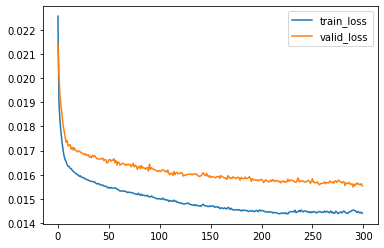

In [6]:
import autorch
model = autorch.utils.PartBulider(clean_df,
                                    x_col,
                                    y_col,
                                    normalize_idx_list=[[0,1]],
                                    hidden_size = 128,
                                    lr = 1e-3,
                                    max_epochs = 300)
model.train()

In [7]:
model.test()

,R2,MSE,MAPE
c620_mf,0.522121,0.00368623,12.4727
t651_mf,0.522121,0.00368623,7.95891
AVG,0.522121,0.00368623,10.2158


In [9]:
x_test = model.data['X_test']
y_real = model.data['Y_test']
y_pred = model.predict(x_test)
test_idx = x_test.index

In [10]:
y_real.head()

,c620_mf,t651_mf
135-058,0.376221,0.623779
059-058,0.287842,0.712158
123-064,0.379584,0.620416
126-049,0.306553,0.693447
078-062,0.253924,0.746076


In [11]:
y_pred.head()

,c620_mf,t651_mf
135-058,0.318221,0.681779
059-058,0.290179,0.709821
123-064,0.381355,0.618645
126-049,0.330021,0.669979
078-062,0.333392,0.666608


In [12]:
y_real.sum(axis=1).head()

135-058    1.0
059-058    1.0
123-064    1.0
126-049    1.0
078-062    1.0
dtype: float32

In [13]:
y_pred.sum(axis=1).head()

135-058    1.0
059-058    1.0
123-064    1.0
126-049    1.0
078-062    1.0
dtype: float32

In [14]:
c620_x = c620_x.loc[test_idx]
t651_x = t651_x.loc[test_idx]
c620_mf = y_pred['c620_mf']
t651_mf = y_pred['t651_mf']

In [15]:
f = lambda x,m:(x.T*m).T
temp1 = f(c620_x,c620_mf)
temp2 = f(t651_x,t651_mf)
temp2.columns = temp1.columns
mix_pred = temp1+temp2
mix_pred.head(3)

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Nitrogen_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Oxygen_wt%
135-058,0.0,0.000089,0.005764,0.011029,0.007683,0.011229,0.017457,42.857947,0.011871,0.019710,0.0,0.005974,54.014583,0.007714,0.006553,0.005391,1.347355,0.617736,0.950579,0.056585,0.011796,2.309096e-08,0.026112,4.256853e-09,5.820301e-

In [16]:
c660_col_names = joblib.load(root+'/col_names/c660_col_names.pkl')
c660_x41_col = c660_col_names['x41']
c660_df = pd.read_csv(root+'/cleaned/c660_train.csv',index_col=0)
mix_real = c660_df[c660_x41_col]
mix_real.columns = mix_pred.columns
mix_real = mix_real.loc[test_idx,:]
mix_real.head(3)

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Nitrogen_wt%,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Oxygen_wt%
135-058,0.0,0.000105,0.006815,0.013040,0.009083,0.013257,0.020548,46.868439,0.013980,0.023194,0.0,0.006590,50.246231,0.007151,0.005998,0.004933,1.232758,0.565287,0.869887,0.051789,0.010792,2.729965e-08,0.023891,5.032731e-09,6.881140e-

In [17]:
model.show_metrics(mix_real,mix_pred)

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Methane_wt%,0.662857,4.24453e-10,12.4727
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Ethane_wt%,0.663053,1.78966e-06,12.4727
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Propane_wt%,0.647409,6.32039e-06,12.4727
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Butane_wt%,0.60655,2.86993e-06,12.3613
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Pentane_wt%,0.340385,4.99321e-06,12.2994
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Hexane_wt%,0.446578,9.60336e-06,11.5064
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%,0.878986,6.68898,3.88939
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Cyclohexane_wt%,0.433352,3.95359e-06,11.497
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_n-Heptane_wt%,0.528891,1.08053e-05,11.3573


In [18]:
model.shrink()

In [19]:
joblib.dump(model,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_mf(82to2).pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_mf(82to2).pkl']